In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pywt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from keras.optimizers import SGD, Adam
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError


In [17]:
df = pd.read_csv("ALL.csv")
df.head()
# print(df.isnull().sum())

,Date_time,BO1013_FLOW1,BO1016_Pressure(m),BO1017_Pressure(m),BO1021_FLOW1),BO1021_Pressure,BO1022_flow1,BO1022_Pressure(m),BO1017_FLOW1,BO1029_FLOW1,...,NB1019_Pressure,NB1020_FLOW1,NB1021_FLOW1,NB1022_FLOW1,TD1029_flow1,TD1029_Pressure,TD1043_FLOW1,TD1043_Press(m),NMNBOOTM1_FLOW1,BOO_TM2_Pressure
0,9/15/2023 0:00,612.8,21.859,20.275,1613.08,13.078,398.4,19.898,3232,201.6,...,17.894,402.0,1672,397.2,231.2,14.863,670.0,24.0,9720.001,12.631
1,9/15/2023 0:15,598.0,22.080,20.556,1540.28,13.038,341.2,20.008,3200,175.2,...,18.245,370.0,1576,360.0,196.4,14.659,577.6,24.0,9000.001,12.600
2,9/15/2023 0:30,585.2,22.268,20.816,1558.08,13.039,344.4,20.462,3168,175.6,...,18.620,356.0,1596,355.2,171.6,14.855,541.2,24.0,8800.001,12.600
3,9/15/2023 0:45,574.0,22.453,21.028,1549.68,13.062,354.4,20.642,3080,152.0,...,18.841,361.6,1612,364.8,173.2,14.855,542.8,24.0,8640.001,12.631
4,9/15/2023 1:00,557.6,22.659,21.274,1442.48,13.023,362.8,20.877,3076,144.0,...,19.191,352.0,1608,368.8,150.8,14.926,526.0,24.0,8480.001,12.631


In [18]:
colum_press = ['BO1016_Pressure(m)', 'BO1017_Pressure(m)', 'BO1021_Pressure', 'BO1022_Pressure(m)', 'BO1029_Pressure(m)', 'NB1019_Pressure', 'TD1029_Pressure', 'TD1043_Press(m)']
df[colum_press] = df[colum_press].apply(lambda x:x+5)
df.describe()

,BO1013_FLOW1,BO1016_Pressure(m),BO1017_Pressure(m),BO1021_FLOW1),BO1021_Pressure,BO1022_flow1,BO1022_Pressure(m),BO1017_FLOW1,BO1029_FLOW1,BO1029_Pressure(m),...,NB1019_Pressure,NB1020_FLOW1,NB1021_FLOW1,NB1022_FLOW1,TD1029_flow1,TD1029_Pressure,TD1043_FLOW1,TD1043_Press(m),NMNBOOTM1_FLOW1,BOO_TM2_Pressure
count,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,...,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000,10464.000000
mean,897.105848,34.012682,30.593451,2236.229687,17.960688,696.098203,28.868620,4602.711391,374.846713,32.558013,...,25.985139,463.360474,2221.482034,709.572898,371.405849,33.082099,966.597286,40.113532,12493.394751,12.846637
std,221.774698,4.346007,3.086398,517.735759,0.213245,225.214997,2.508309,951.762711,166.142653,8.380472,...,2.258927,104.588792,514.698097,228.019936,164.914015,8.431778,565.160088,7.079430,2877.066060,0.261680
min,70.800000,3.307000,18.120000,46.400000,17.529000,82.000000,4.444000,0.000000,0.000000,12.897000,...,0.780000,0.000000,40.000000,0.000000,0.000000,13.340000,0.000000,5.000000,0.000000,12.459000
25%,686.000000,29.274750,27.748750,1843.400000,17.796000,478.000000,27.240000,3752.000000,248.800000,21.602250,...,25.044750,366.000000,1828.000000,489.100000,246.000000,22.134000,482.400000,32.000000,9840.001000,12.655000
50%,978.000000,36.115000,31.837000,2382.000000,17.921000,772.400000,29.448000,4972.000000,364.000000,36.429000,...,26.326000,496.800000,2368.000000,787.600000,360.400000,36.966000,1139.600000,43.500000,13560.000000,12.733000
75%,1070.400000,37.329250,32.975000,2566.800000,18.093000,869.600000,30.607000,5332.000000,488.800000,39.313000,...,27.348250,545.600000,2552.000000,885.200000,484.800000,39.855000,1441.600000,46.000000,14800.000000,12.999000
max,1240.400000,41.489000,37.228000,4124.000000,18.712000,1218.000000,35.963000,6044.000000,899.600000,42.749000,...,33.700000,730.400000,4096.000000,1224.000000,893.200000,44.554000,1915.200000,50.500000,16480.000000,13.704000


In [19]:
#doc dataset
df = pd.read_csv("ALL.csv")
df.head()
print(df.isnull().sum())
#xử lí giá trị âm
colum_press = ['BO1016_Pressure(m)', 'BO1017_Pressure(m)', 'BO1021_Pressure', 'BO1022_Pressure(m)', 'BO1029_Pressure(m)', 'NB1019_Pressure', 'TD1029_Pressure', 'TD1043_Press(m)']
df[colum_press] = df[colum_press].apply(lambda x:x+5)
df.describe()
#tách tập trạng thái và tập điều khiển
df.set_index("Date_time", inplace=True) #set index

state_ = df.drop([ "BOO_TM2_Pressure"], axis = 1)
features = state_.columns
scaler =MMS() #scale data
state = scaler.fit_transform(state_[features])
state = pd.DataFrame(columns=features, data=state, index = df.index)
print(state.head())

df["BOO_TM2_Pressure"] = scaler.fit_transform(df[["BOO_TM2_Pressure"]])
control = df["BOO_TM2_Pressure"]

Date_time             0
BO1013_FLOW1          0
BO1016_Pressure(m)    0
BO1017_Pressure(m)    0
BO1021_FLOW1)         0
BO1021_Pressure       0
BO1022_flow1          0
BO1022_Pressure(m)    0
BO1017_FLOW1          0
BO1029_FLOW1          0
BO1029_Pressure(m)    0
NB1013_FLOW1          0
NB1017_FLOW1          0
NB1017_Pressure       0
NB1019_FLOW1          0
NB1019_Pressure       0
NB1020_FLOW1          0
NB1021_FLOW1          0
NB1022_FLOW1          0
TD1029_flow1          0
TD1029_Pressure       0
TD1043_FLOW1          0
TD1043_Press(m)       0
NMNBOOTM1_FLOW1       0
BOO_TM2_Pressure      0
dtype: int64
                BO1013_FLOW1  BO1016_Pressure(m)  BO1017_Pressure(m)  \
Date_time                                                              
9/15/2023 0:00      0.463406            0.616835            0.374450   
9/15/2023 0:15      0.450752            0.622623            0.389156   
9/15/2023 0:30      0.439808            0.627547            0.402763   
9/15/2023 0:45      0.43023

In [24]:
'''# ax = plt.gca()
# X.plot(kind='line',
       
#         y='BO1013_FLOW1',
#         color='green', ax=ax, figsize = (16,6))'''

"# ax = plt.gca()\n# X.plot(kind='line',\n       \n#         y='BO1013_FLOW1',\n#         color='green', ax=ax, figsize = (16,6))"

In [20]:
dense_act3 = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu'] 
recur_act3 = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu']
epoch3 = [100]
learning_r3 = [0.001] 
ls = 'mae' 
print('yes')
kind = []
sc = []

yes


In [21]:
'''Model 5 seems fine , ĐC RỒI ĐỂ ĐÓ ĐI, MODEL CHỈ DÙNG 1 lstm LÊN TRÊN TẬP CONTROL''' 
dense_act5 = 'selu' 
recur_act5 = 'sigmoid' 
epoch5 = 1000 
learning_r5 = 0.0005
ls = 'mae' 
opt = SGD(learning_rate= learning_r5)
model5 = Sequential([
                         tf.keras.layers.LSTM(64, recurrent_activation = 'sigmoid', input_shape = [5, 1]),
                         tf.keras.layers.Dropout(0.1),
                         tf.keras.layers.Dense(32, activation = 'selu'),
                         tf.keras.layers.Dropout(0.1),
                         tf.keras.layers.Dense(16, activation = 'selu'),
                         tf.keras.layers.Dense(8, activation = 'selu'),
                         tf.keras.layers.Dense(1)
                         ])
model5.compile(optimizer = opt, loss = ls, )
apply5 = model5.fit(X_control_tr, y_control_tr,
                  batch_size = 1024,
                  epochs = epoch5,
                 validation_split = 0.2)
score5 = model5.evaluate(X_control_te, y_control_te)
score5

Epoch 1/1000
7/7 [==============================] - 6s 213ms/step - loss: 0.3992 - val_loss: 0.2508
Epoch 2/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.2468 - val_loss: 0.2255
Epoch 3/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.2343 - val_loss: 0.2159
Epoch 4/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.2247 - val_loss: 0.2084
Epoch 5/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.2134 - val_loss: 0.2015
Epoch 6/1000
7/7 [==============================] - 0s 31ms/step - loss: 0.2105 - val_loss: 0.1952
Epoch 7/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.2032 - val_loss: 0.1890
Epoch 8/1000
7/7 [==============================] - 0s 29ms/step - loss: 0.1979 - val_loss: 0.1831
Epoch 9/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.1898 - val_loss: 0.1777
Epoch 10/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.1868 - val_loss: 0.1724
Epoch 11

7/7 [==============================] - 0s 33ms/step - loss: 0.0628 - val_loss: 0.0461
Epoch 84/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.0629 - val_loss: 0.0460
Epoch 85/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0627 - val_loss: 0.0457
Epoch 86/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.0618 - val_loss: 0.0455
Epoch 87/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0622 - val_loss: 0.0453
Epoch 88/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0613 - val_loss: 0.0452
Epoch 89/1000
7/7 [==============================] - 0s 51ms/step - loss: 0.0620 - val_loss: 0.0449
Epoch 90/1000
7/7 [==============================] - 0s 50ms/step - loss: 0.0613 - val_loss: 0.0448
Epoch 91/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0599 - val_loss: 0.0446
Epoch 92/1000
7/7 [==============================] - 0s 52ms/step - loss: 0.0598 - val_loss: 0.0444
Epoch 93/1000


7/7 [==============================] - 0s 51ms/step - loss: 0.0505 - val_loss: 0.0395
Epoch 165/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0513 - val_loss: 0.0395
Epoch 166/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0516 - val_loss: 0.0395
Epoch 167/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.0511 - val_loss: 0.0394
Epoch 168/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0503 - val_loss: 0.0395
Epoch 169/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0507 - val_loss: 0.0394
Epoch 170/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0499 - val_loss: 0.0394
Epoch 171/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0504 - val_loss: 0.0393
Epoch 172/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0506 - val_loss: 0.0393
Epoch 173/1000
7/7 [==============================] - 0s 50ms/step - loss: 0.0501 - val_loss: 0.0393
Epoch

7/7 [==============================] - 0s 41ms/step - loss: 0.0479 - val_loss: 0.0385
Epoch 246/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0474 - val_loss: 0.0385
Epoch 247/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0471 - val_loss: 0.0385
Epoch 248/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.0467 - val_loss: 0.0385
Epoch 249/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0476 - val_loss: 0.0386
Epoch 250/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0469 - val_loss: 0.0386
Epoch 251/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0475 - val_loss: 0.0385
Epoch 252/1000
7/7 [==============================] - 0s 61ms/step - loss: 0.0472 - val_loss: 0.0386
Epoch 253/1000
7/7 [==============================] - 0s 62ms/step - loss: 0.0474 - val_loss: 0.0385
Epoch 254/1000
7/7 [==============================] - 0s 54ms/step - loss: 0.0476 - val_loss: 0.0386
Epoch

7/7 [==============================] - 0s 33ms/step - loss: 0.0460 - val_loss: 0.0382
Epoch 327/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.0460 - val_loss: 0.0381
Epoch 328/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0464 - val_loss: 0.0381
Epoch 329/1000
7/7 [==============================] - 0s 41ms/step - loss: 0.0459 - val_loss: 0.0381
Epoch 330/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0456 - val_loss: 0.0381
Epoch 331/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0452 - val_loss: 0.0381
Epoch 332/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0457 - val_loss: 0.0381
Epoch 333/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0458 - val_loss: 0.0380
Epoch 334/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0450 - val_loss: 0.0380
Epoch 335/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.0460 - val_loss: 0.0380
Epoch

7/7 [==============================] - 0s 48ms/step - loss: 0.0456 - val_loss: 0.0379
Epoch 408/1000
7/7 [==============================] - 0s 47ms/step - loss: 0.0446 - val_loss: 0.0377
Epoch 409/1000
7/7 [==============================] - 0s 46ms/step - loss: 0.0453 - val_loss: 0.0378
Epoch 410/1000
7/7 [==============================] - 0s 49ms/step - loss: 0.0448 - val_loss: 0.0377
Epoch 411/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0446 - val_loss: 0.0376
Epoch 412/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0447 - val_loss: 0.0377
Epoch 413/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0446 - val_loss: 0.0377
Epoch 414/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0453 - val_loss: 0.0377
Epoch 415/1000
7/7 [==============================] - 0s 41ms/step - loss: 0.0457 - val_loss: 0.0378
Epoch 416/1000
7/7 [==============================] - 0s 61ms/step - loss: 0.0446 - val_loss: 0.0376
Epoch

7/7 [==============================] - 0s 38ms/step - loss: 0.0439 - val_loss: 0.0374
Epoch 489/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.0443 - val_loss: 0.0374
Epoch 490/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0446 - val_loss: 0.0377
Epoch 491/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.0439 - val_loss: 0.0374
Epoch 492/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.0441 - val_loss: 0.0374
Epoch 493/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.0437 - val_loss: 0.0374
Epoch 494/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0442 - val_loss: 0.0374
Epoch 495/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0436 - val_loss: 0.0375
Epoch 496/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.0439 - val_loss: 0.0373
Epoch 497/1000
7/7 [==============================] - 0s 50ms/step - loss: 0.0439 - val_loss: 0.0373
Epoch

7/7 [==============================] - 0s 33ms/step - loss: 0.0437 - val_loss: 0.0371
Epoch 570/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.0431 - val_loss: 0.0371
Epoch 571/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0431 - val_loss: 0.0371
Epoch 572/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.0430 - val_loss: 0.0371
Epoch 573/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.0426 - val_loss: 0.0375
Epoch 574/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.0433 - val_loss: 0.0371
Epoch 575/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0434 - val_loss: 0.0371
Epoch 576/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.0434 - val_loss: 0.0370
Epoch 577/1000
7/7 [==============================] - 0s 47ms/step - loss: 0.0433 - val_loss: 0.0371
Epoch 578/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.0433 - val_loss: 0.0371
Epoch

7/7 [==============================] - 1s 85ms/step - loss: 0.0427 - val_loss: 0.0369
Epoch 651/1000
7/7 [==============================] - 1s 83ms/step - loss: 0.0422 - val_loss: 0.0369
Epoch 652/1000
7/7 [==============================] - 1s 83ms/step - loss: 0.0432 - val_loss: 0.0370
Epoch 653/1000
7/7 [==============================] - 1s 80ms/step - loss: 0.0434 - val_loss: 0.0368
Epoch 654/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.0422 - val_loss: 0.0368
Epoch 655/1000
7/7 [==============================] - 0s 73ms/step - loss: 0.0422 - val_loss: 0.0369
Epoch 656/1000
7/7 [==============================] - 0s 73ms/step - loss: 0.0435 - val_loss: 0.0370
Epoch 657/1000
7/7 [==============================] - 1s 87ms/step - loss: 0.0431 - val_loss: 0.0369
Epoch 658/1000
7/7 [==============================] - 1s 87ms/step - loss: 0.0434 - val_loss: 0.0369
Epoch 659/1000
7/7 [==============================] - 1s 106ms/step - loss: 0.0421 - val_loss: 0.0368
Epoc

7/7 [==============================] - 0s 53ms/step - loss: 0.0428 - val_loss: 0.0368
Epoch 732/1000
7/7 [==============================] - 0s 46ms/step - loss: 0.0423 - val_loss: 0.0367
Epoch 733/1000
7/7 [==============================] - 0s 49ms/step - loss: 0.0422 - val_loss: 0.0366
Epoch 734/1000
7/7 [==============================] - 0s 55ms/step - loss: 0.0423 - val_loss: 0.0366
Epoch 735/1000
7/7 [==============================] - 0s 55ms/step - loss: 0.0420 - val_loss: 0.0367
Epoch 736/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0429 - val_loss: 0.0366
Epoch 737/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0424 - val_loss: 0.0367
Epoch 738/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0424 - val_loss: 0.0367
Epoch 739/1000
7/7 [==============================] - 0s 49ms/step - loss: 0.0420 - val_loss: 0.0366
Epoch 740/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.0431 - val_loss: 0.0367
Epoch

7/7 [==============================] - 0s 55ms/step - loss: 0.0421 - val_loss: 0.0366
Epoch 813/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0423 - val_loss: 0.0365
Epoch 814/1000
7/7 [==============================] - 0s 49ms/step - loss: 0.0421 - val_loss: 0.0368
Epoch 815/1000
7/7 [==============================] - 0s 46ms/step - loss: 0.0424 - val_loss: 0.0367
Epoch 816/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0418 - val_loss: 0.0370
Epoch 817/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0414 - val_loss: 0.0367
Epoch 818/1000
7/7 [==============================] - 0s 54ms/step - loss: 0.0419 - val_loss: 0.0365
Epoch 819/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.0422 - val_loss: 0.0365
Epoch 820/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.0426 - val_loss: 0.0365
Epoch 821/1000
7/7 [==============================] - 0s 59ms/step - loss: 0.0423 - val_loss: 0.0365
Epoch

7/7 [==============================] - 0s 54ms/step - loss: 0.0417 - val_loss: 0.0364
Epoch 894/1000
7/7 [==============================] - 0s 48ms/step - loss: 0.0420 - val_loss: 0.0365
Epoch 895/1000
7/7 [==============================] - 0s 60ms/step - loss: 0.0413 - val_loss: 0.0363
Epoch 896/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.0416 - val_loss: 0.0365
Epoch 897/1000
7/7 [==============================] - 1s 86ms/step - loss: 0.0415 - val_loss: 0.0363
Epoch 898/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.0427 - val_loss: 0.0364
Epoch 899/1000
7/7 [==============================] - 0s 58ms/step - loss: 0.0422 - val_loss: 0.0364
Epoch 900/1000
7/7 [==============================] - 0s 47ms/step - loss: 0.0414 - val_loss: 0.0363
Epoch 901/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0415 - val_loss: 0.0363
Epoch 902/1000
7/7 [==============================] - 0s 62ms/step - loss: 0.0415 - val_loss: 0.0368
Epoch

7/7 [==============================] - 0s 49ms/step - loss: 0.0420 - val_loss: 0.0363
Epoch 975/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.0415 - val_loss: 0.0363
Epoch 976/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0412 - val_loss: 0.0364
Epoch 977/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0412 - val_loss: 0.0364
Epoch 978/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.0421 - val_loss: 0.0362
Epoch 979/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.0416 - val_loss: 0.0362
Epoch 980/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.0416 - val_loss: 0.0364
Epoch 981/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.0416 - val_loss: 0.0365
Epoch 982/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0417 - val_loss: 0.0362
Epoch 983/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0411 - val_loss: 0.0364
Epoch

0.0338609553873539

In [13]:
'''LSTM1 áp dụng lên tập control, window = 5'''
def control_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)
X_control , y_control = control_X_y(control, 5)
X_control.shape , y_control.shape
X_control_tr, X_control_te, y_control_tr, y_control_te = train_test_split(X_control, y_control, test_size = 0.25, random_state = 25)
print(y_control_tr[:5]) 
y_control_tr.shape

[0.44658635 0.04417671 0.13172691 0.62891566 0.15742972]


(7844,)

In [ ]:
for i in dense_act3:
    for j in recur_act3:
        for m in epoch3:
            for n in learning_r3:
                opt = SGD(learning_rate= n)
                model3 = Sequential([
                         tf.keras.layers.LSTM(64, recurrent_activation = j, input_shape = [5, 1]),
                         tf.keras.layers.Dropout(0.1),
                         tf.keras.layers.Dense(32, activation = i),
                         tf.keras.layers.Dropout(0.1),
                         tf.keras.layers.Dense(16, activation = i),
                         tf.keras.layers.Dense(8, activation = i),
                         tf.keras.layers.Dense(1)
                         ])
                model3.compile(optimizer = opt, loss = ls, )
                apply3 = model3.fit(X_control_tr, y_control_tr, batch_size = 1024, epochs = m, validation_split = 0.2)
                name = "model: "+ "dense_act3 "+ i+ " recur_act3 "+ j + " epoch3: " + str(m) +" ls "+ str(n)
                score = model3.evaluate(X_control_te, y_control_te)
                kind.append(name)
#                 kind.append(score)
                sc.append(score)
a = np.min(sc)
b = sc.index(a)
print("loss_min "+str(a))
print(kind[b])

In [8]:
'''plot cho model5'''
from sklearn.metrics import mean_absolute_error as mae
def plot_predictions1(model, X, y_scaled, start=0, end=100):
    y_pred_scaled = model.predict(X).flatten()
    predictions = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.figure(figsize=(20,10))
    plt.plot(df['Predictions'][start:end], label = 'Pre')
    plt.plot(df['Actuals'][start:end], label = 'Actual')
    plt.legend()
    return df, mae(y, predictions)

82/82 [==============================] - 1s 3ms/step


(      Predictions  Actuals
 0       12.630700   12.631
 1       12.630085   12.639
 2       13.297360   13.320
 3       13.239787   13.297
 4       12.652880   12.647
 ...           ...      ...
 2610    12.743705   12.733
 2611    12.702221   12.702
 2612    13.075467   13.038
 2613    12.636950   12.631
 2614    12.605106   12.600
 
 [2615 rows x 2 columns],
 0.04486462158144768)

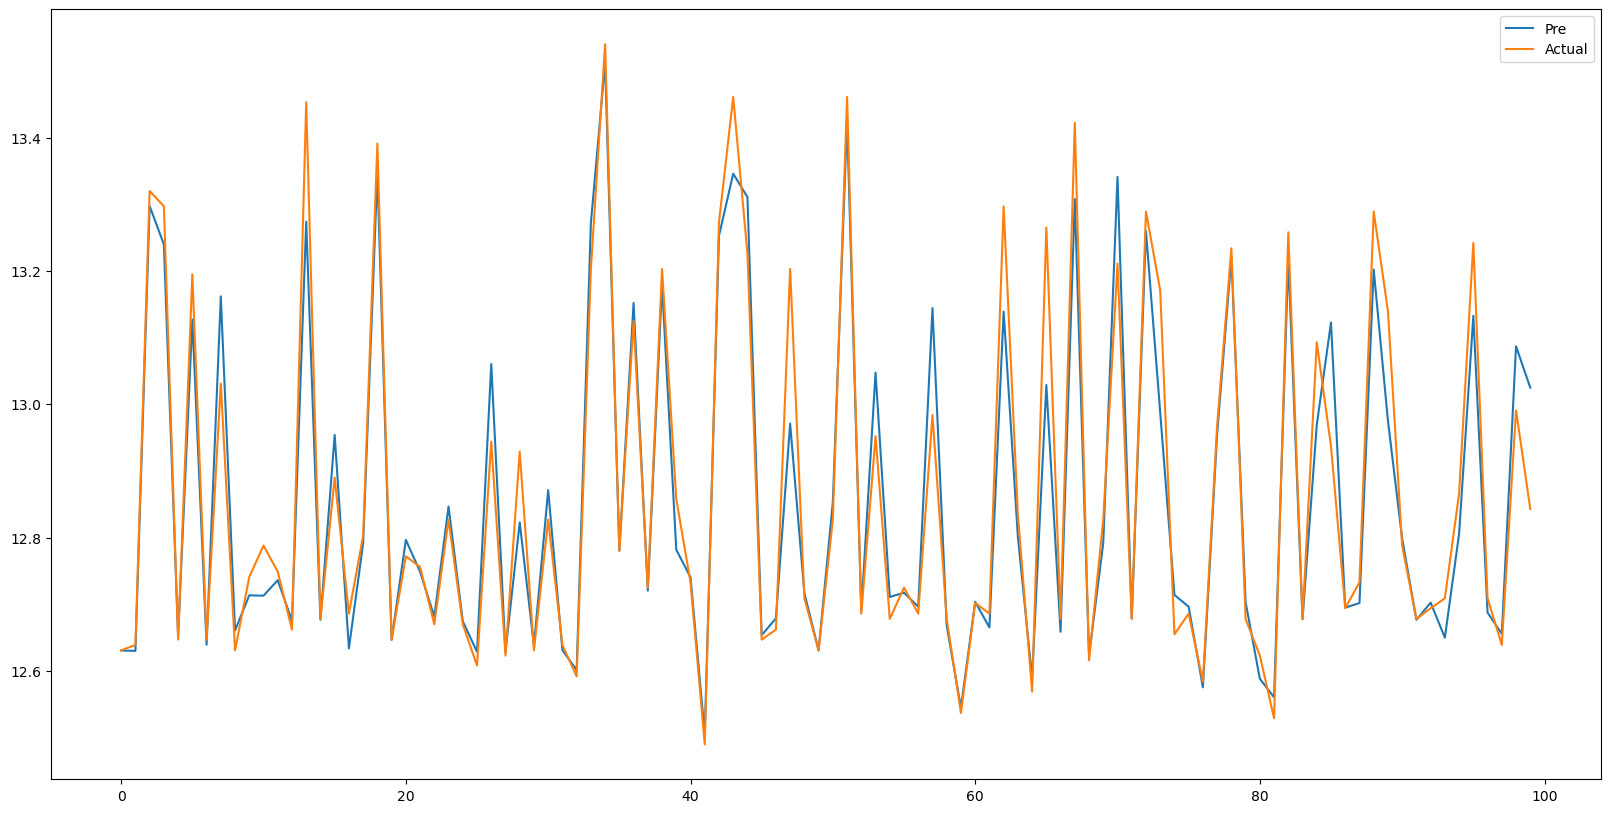

In [9]:
plot_predictions1(model5, X_control_te, y_control_te)